In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import json
import os
from os import listdir
from os.path import isfile, join
from pycocotools import mask as _mask
import torch

import helper
import visualization
from visualization import *
from CutLER import *
from helper import *

p = 4
plt.rcParams['figure.figsize'] = [1.5*p,p]

## Initialization

#### Path to datasets, annotations

In [2]:
# path to data/annotations in "system" format
syspath="/home/dkhatanassia/detectron2_dataset"

#*************************************** datasets *****************************************
dataset_train = 'jerry_real'
dataset_test = 'jerry_real'
DPI = 50
#******************************************************************************************

# root
root_train = join(syspath,dataset_train)
root_test = join(syspath,dataset_test)

# path to images{train, test}
imgs_train = join(root_train,'imgs')
imgs_test = join(root_test,'_imgs')

# path to json{train, test}
json_name_GT = f'GT_{dataset_test}.json'
json_name_GT_tr = f'tr_GT_{dataset_train}.json'
json_name_GT_te = f'te_GT_{dataset_test}.json'
json_name_mc = f'mc_{dataset_test}.json'
json_name_mc_tr = f'tr_mc_{dataset_train}.json'
json_name_mc_te = f'te_mc_{dataset_test}.json'

json_path_GT = join(root_test,'annotations',json_name_GT)
json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
json_path_mc = join(root_test,'annotations',json_name_mc)
json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
json_path_mc_te = join(root_test,'annotations',json_name_mc_te)

# builtin datasets location
%cd ~/CutLER/cutler
os.environ['DETECTRON2_DATASETS']='/home/dkhatanassia/CutLER/cutler/datasets'
print(os.getenv('DETECTRON2_DATASETS'))

/home/dkhatanassia/CutLER/cutler
/home/dkhatanassia/CutLER/cutler/datasets


#### Register datasets to detectron2

In [3]:
# register datasets
d2name = [
    json_name_GT,
    json_name_GT_tr,
    json_name_GT_te,
    json_name_mc,
    json_name_mc_tr,
    json_name_mc_te]

d2imgs = [
    imgs_test,
    imgs_train,
    imgs_test,
    imgs_test,
    imgs_train,
    imgs_test]

d2json = [
    json_path_GT,
    json_path_GT_tr,
    json_path_GT_te,
    json_path_mc,
    json_path_mc_tr,
    json_path_mc_te]

for key in range(len(d2name)):
    if not os.path.exists(d2json[key]): continue
    registerCatalog(d2name[key],d2json[key],d2imgs[key])

registered: GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_GT_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_GT_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_mc_jerry_real.json
json 

#### RGB mean std 

In [4]:
if False: 
    means = []
    stds = []

    image_paths = [join(imgs_train,f) for f in listdir(imgs_train) if f.endswith('.jpg')]

    for idx in range(0,len(image_paths),50):
        sub = image_paths[idx:idx+50]
        tmp = np.array([cv2.imread(im,cv2.IMREAD_COLOR) for im in sub])
        mean = np.mean(tmp, axis=(0, 1, 2))
        std = np.std(tmp, axis=(0, 1, 2))
        
        means.append(mean)
        stds.append(std)
        
    mean=np.mean(np.vstack(means),axis=0)
    std=np.mean(np.vstack(stds),axis=0)

    print(f'RGB mean: {mean}\nRGB std: {std}')

#### Path to weights, outputs, ...

In [5]:
# current round
rnd = 4

# path to output for current round
p2o = join(root_train,f'rd{rnd-1}-{rnd}')
if not os.path.exists(p2o):
    os.makedirs(p2o)
    print(f'created: {p2o}\n')
    
p2cfg = 'model_zoo/configs/CutLER-ImageNet/realinf_cascade_mask_rcnn_R_50_FPN.yaml'
p2w = '/home/dkhatanassia/CutLER/cutler/weights/jerry_sp10.pth'


#**** ANNOTATIONS *****
# path to new predictions
p2np =join(p2o,'inference/coco_instances_results.json')
# path to previous json
p2pj_tr = json_path_mc_tr
p2pj_te = json_path_mc_te

dict_path = {
    'config':p2cfg,
    'output':p2o,
    'new predictions':p2np,
    'prev json_tr':p2pj_tr,
    'prev json_te': p2pj_te}

print(f'ROUND: {rnd}')
[print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


ROUND: 4
path to config: model_zoo/configs/CutLER-ImageNet/realinf_cascade_mask_rcnn_R_50_FPN.yaml
path to output: ./rd3-4
path to new predictions: ./rd3-4/inference/coco_instances_results.json
path to prev json_tr: ./annotations/tr_mc_jerry_real.json
path to prev json_te: ./annotations/te_mc_jerry_real.json


[None, None, None, None, None]

#### Generate pseudo GT (use mc files)

In [6]:
dpi = 50
th = 0.95

In [7]:
if False:
    clearAnnotations(p2pj_tr)

    # train - generate using dpi
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file '{p2cfg}' \
    --test-dataset '{json_name_mc_tr}' \
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
    OUTPUT_DIR '{p2o}'
    # train - threshold
    %cd ~/CutLER/cutler/tools
    %run get_self_training_ann.py \
    --new-pred '{p2np}' \
    --prev-ann '{p2pj_tr}'  \
    --save-path '{p2pj_tr}' \
    --threshold '{th}'

registered: tr_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/tr_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs



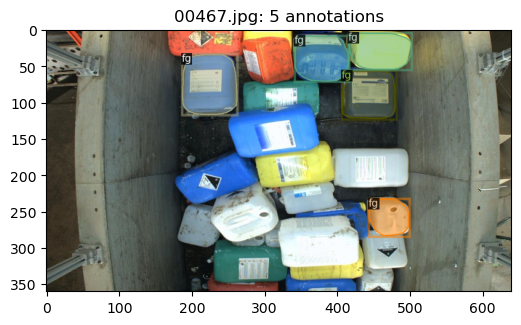

In [8]:
registerCatalog(json_name_mc_tr,json_path_mc_tr,imgs_train)
visualizeSample(417, json_name_mc_tr)

In [9]:
if False:
    clearAnnotations(p2pj_te)

    # test - generate using dpi
    %cd ~/CutLER/cutler
    %run train_net.py --num-gpus 1 \
    --config-file '{p2cfg}' \
    --test-dataset '{json_name_mc_te}' \
    --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
    OUTPUT_DIR '{p2o}'
    # test - threshold
    %cd ~/CutLER/cutler/tools
    %run get_self_training_ann.py \
    --new-pred '{p2np}' \
    --prev-ann '{p2pj_te}'  \
    --save-path '{p2pj_te}' \
    --threshold '{th}'

registered: te_mc_jerry_real.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/annotations/te_mc_jerry_real.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs



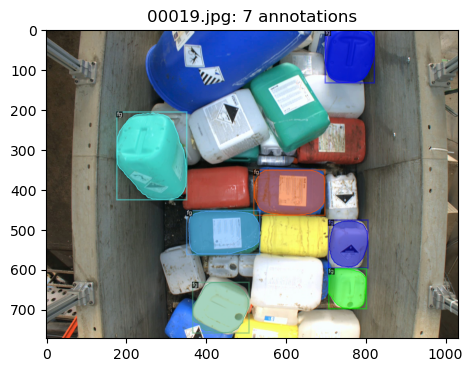

In [10]:
registerCatalog(json_name_mc_te,json_path_mc_te,imgs_test)
visualizeSample(5, json_name_mc_te)

## DropLoss4: weights(jerry_sp10_rd3) -> train to get weights(4)

In [11]:
torch.cuda.empty_cache()
infos=torch.cuda.memory_summary()
print(str(infos))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [12]:
prev_rnd_name_tr = json_name_mc_tr
prev_rnd_name_te = json_name_mc_te

if False:
    for i in range(20):
        #********************************* TRAIN ***************************************************
        '''
        Train using:
        - p2cfg: path to config file
        - prev_rnd_name_tr: name of training catalog containing latest augmented pseudo GT (???)
        - json_name_GT_te: name of test catalog containing SA GT
        - p2w: path to weights outputed by previous round
        - p2o: where to store related files 
        '''
        #!rm '{join(p2o,"metrics.json")}'
        %cd ~/CutLER/cutler
        %run train_net.py --num-gpus 1 \
        --config-file '{p2cfg}'\
        --train-dataset '{prev_rnd_name_tr}' \
        --test-dataset '{json_name_GT_te}' \
        MODEL.WEIGHTS '{p2w}' \
        OUTPUT_DIR '{p2o}'
        
        #**************************** UPDATE SOME PATHS *******************************************
        '''
        Training is complete:
        - save path to previous weights in p2pw
        - update path to weights 
        - create path to test, directory to store test results
        '''
        p2pw = p2w
        p2w = join(p2o,'model_final.pth')
        p2t = join(p2o,f'eval_{rnd-1}to{rnd}')
        os.makedirs(p2t,exist_ok=True)
        
        #******************************* PLOT LOSS ****************************************
        '''
        Plot loss and store the graph in p2t
        '''
        plotTrainingInfo(p2o,p2t,rnd,dataset_train)
        
        #************************ TEST INTERMEDIATE WEIGHTS ***************************
        '''
        Test intermediate weights
        '''
        iter_inter = 200
        iter_final = 1100

        from helper import init_df, get_results
        df_bbox = init_df(p2o)
        df_segm = init_df(p2o)
            
        nb_weights = len([d for d in listdir(p2o) if '.pth' in d])
        for i in range(nb_weights+1):
            if i==0: 
                # initial
                value = 0
                weights_tested = p2pw
            else:
                # checkpoints
                if i<nb_weights: 
                    if value == 0: value+=iter_inter-1
                    else: value+=iter_inter
                    weights_tested = join(p2o,f'model_{str(value).zfill(7)}.pth')
                # final
                else:
                    value = iter_final
                    weights_tested = p2w
            
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{p2cfg}' \
            --test-dataset '{json_name_GT_te}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{DPI}'\
            MODEL.WEIGHTS '{weights_tested}' \
            OUTPUT_DIR '{p2t}'
                
            get_results(p2t,df_bbox,df_segm,value)
        
        df_bbox['CP_nb']=df_bbox['CP_nb'].astype(int)
        df_segm['CP_nb']=df_segm['CP_nb'].astype(int)
        # save csv
        df_bbox.to_csv(join(p2t,'bbox.csv'), index=False)
        df_segm.to_csv(join(p2t,'segm.csv'), index=False)
        
        plotTestInfo(p2t,rnd,dataset_test)
        
        #************************ DPI TH ***************************
        p2dpith = join(p2o,'DPI_th')
        DPIs = [1,5,10,50]
        ths = [0.01] + list(np.arange(0.5,1,0.05).round(2)) + [0.99]

        for dpi in DPIs:
            %cd ~/CutLER/cutler
            %run train_net.py --num-gpus 1 \
            --config-file '{p2cfg}' \
            --test-dataset '{json_name_mc_te}'\
            --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}'\
            MODEL.WEIGHTS '{p2w}' \
            OUTPUT_DIR '{p2dpith}'
                
            for tmp_th in ths:
                tmp_pred = join(p2dpith,'inference','coco_instances_results.json')
                tmp_rnd_name = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{tmp_th}.json'
                tmp_new = join(p2dpith,tmp_rnd_name)
            
                %cd ~/CutLER/cutler/tools
                %run get_self_training_ann.py \
                --new-pred '{tmp_pred}' \
                --prev-ann '{p2pj_te}'  \
                --save-path '{tmp_new}' \
                --threshold '{tmp_th}'
                
        plotDPIthInfo(p2dpith,rnd,DPIs,ths,dataset_test,json_path_GT_te)
        
        
        #************* USING THE NEW WEIGHTS, UPDATE PSEUDO GT ***************************
        dpi = 50
        th = 0.95

        rnd_name_tr = f'tr_{dataset_train}_rd{rnd}_DPI{dpi}_th{th}.json'
        p2nj_tr = join(p2o,rnd_name_tr)

        rnd_name_te = f'te_{dataset_test}_rd{rnd}_DPI{dpi}_th{th}.json'
        p2nj_te = join(p2o,rnd_name_te)


        print(f'path to previous json: {p2pj_tr}, {p2pj_te}\npathto new json: {p2nj_tr}, {p2nj_te}')
        # train - generate using dpi
        %cd ~/CutLER/cutler
        %run train_net.py --num-gpus 1 \
        --config-file '{p2cfg}' \
        --test-dataset '{json_name_mc_tr}' \
        --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
        MODEL.WEIGHTS '{p2w}' \
        OUTPUT_DIR '{p2o}'
        # train - threshold
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{p2np}' \
        --prev-ann '{p2pj_tr}'  \
        --save-path '{p2nj_tr}' \
        --threshold '{th}'

        # test - generate using dpi
        %cd ~/CutLER/cutler
        %run train_net.py --num-gpus 1 \
        --config-file '{p2cfg}' \
        --test-dataset '{json_name_mc_te}' \
        --eval-only TEST.DETECTIONS_PER_IMAGE '{dpi}' \
        MODEL.WEIGHTS '{p2w}' \
        OUTPUT_DIR '{p2o}'
        # test - threshold
        %cd ~/CutLER/cutler/tools
        %run get_self_training_ann.py \
        --new-pred '{p2np}' \
        --prev-ann '{p2pj_te}'  \
        --save-path '{p2nj_te}' \
        --threshold '{th}'

        # register datasets
        d2name = [rnd_name_tr,rnd_name_te]
        d2imgs = [imgs_train,imgs_test]
        d2json = [p2nj_tr,p2nj_te]

        for key in range(len(d2name)):
            registerCatalog(d2name[key],d2json[key],d2imgs[key])
            
            
        # current round
        rnd += 1

        # path to output for current round
        p2o = join(root_train,f'rd{rnd-1}-{rnd}')
            
        if not os.path.exists(p2o):
            os.makedirs(p2o)
            print(f'created: {p2o}\n')
            
        #**** ANNOTATIONS *****
        # path to new predictions
        p2np =join(p2o,'inference/coco_instances_results.json')

        # path to previous json
        prev_rnd_name_tr = rnd_name_tr
        prev_rnd_name_te = rnd_name_te 

        p2pj_tr = p2nj_tr
        p2pj_te = p2nj_te

        dict_path = {
            'config':p2cfg,
            'output':p2o,
            'weigths':p2w,
            'new predictions':p2np,
            'prev json_tr':p2pj_tr,
            'prev json_te': p2pj_te}

        print(f'ROUND: {rnd}')
        [print(f'path to {d}: {dict_path[d].replace(root_train,".")}') for d in dict_path]


In [13]:
dpi = 50
th = 0.95

count_tr = []
count_te = []

for rd in range(4,23+1):
    # path to output for current round
    p2o = join(root_train,f'rd{rd-1}-{rd}')
    
    rnd_name_tr = f'tr_{dataset_test}_rd{rd}_DPI{dpi}_th{th}.json'
    p2nj_tr = join(p2o,rnd_name_tr)

    rnd_name_te = f'te_{dataset_test}_rd{rd}_DPI{dpi}_th{th}.json'    
    p2nj_te = join(p2o,rnd_name_te)
    
    # register datasets
    d2name = [rnd_name_tr,rnd_name_te]
    d2imgs = [imgs_train,imgs_test]
    d2json = [p2nj_tr,p2nj_te]

    for key in range(len(d2name)):
        registerCatalog(d2name[key],d2json[key],d2imgs[key])    
    
    tmp_tr = DatasetCatalog.get(rnd_name_tr)
    tmp_te = DatasetCatalog.get(rnd_name_te)
    
    count_tr.append(sum([len(i['annotations']) for i in tmp_tr]))
    count_te.append(sum([len(i['annotations']) for i in tmp_te]))
    

count_GT_te =sum([len(i['annotations']) for i in DatasetCatalog.get(json_name_GT_te)])

registered: tr_jerry_real_rd4_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd3-4/tr_jerry_real_rd4_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_jerry_real_rd4_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd3-4/te_jerry_real_rd4_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_jerry_real_rd5_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd4-5/tr_jerry_real_rd5_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/imgs

registered: te_jerry_real_rd5_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd4-5/te_jerry_real_rd5_DPI50_th0.95.json
imgs are at: /home/dkhatanassia/detectron2_dataset/jerry_real/_imgs

registered: tr_jerry_real_rd6_DPI50_th0.95.json
json is: /home/dkhatanassia/detectron2_dataset/jerry_real/rd5-6/tr_jerry_real_rd6_DPI5

Text(0, 0.5, 'Nb annotations')

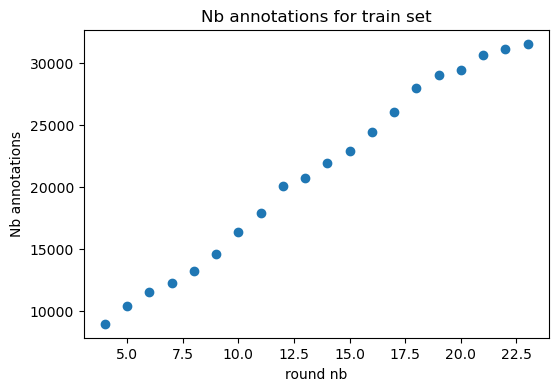

In [14]:
plt.scatter(np.arange(4,23+1,1),count_tr)
plt.title('Nb annotations for train set')
plt.xlabel('round nb')
plt.ylabel('Nb annotations')

Text(0, 0.5, 'Nb annotations')

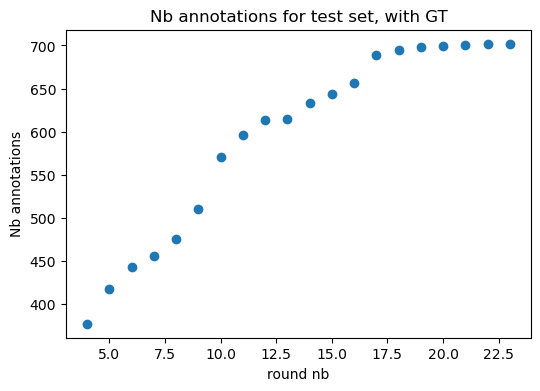

In [15]:
plt.scatter(np.arange(4,23+1,1),count_te)
#plt.axhline(y=count_GT_te, color='pink', linestyle='--')
plt.title('Nb annotations for test set, with GT')
plt.xlabel('round nb')
plt.ylabel('Nb annotations')

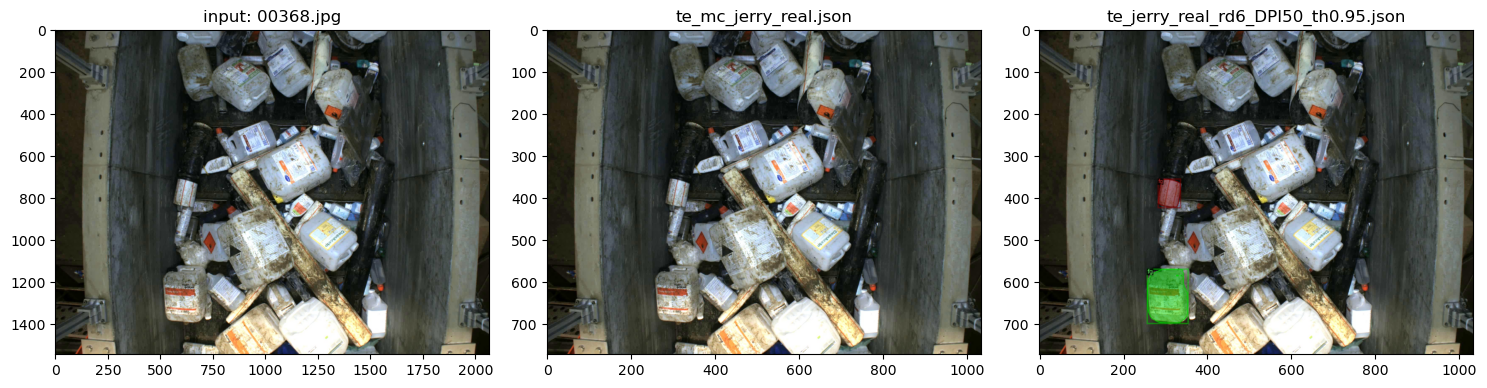

In [25]:
rd = 6
smpl = 49

show0_te = json_name_mc_te
show0_tr = json_name_mc_tr
showlast_tr = f'tr_jerry_real_rd{rd}_DPI50_th0.95.json'
showlast_te = f'te_jerry_real_rd{rd}_DPI50_th0.95.json'

saveto = join(p2o, 'visu')
os.makedirs(saveto,exist_ok=True)
visualizePseudoGT(smpl, show0_te,showlast_te,p=15,saveto=False)

## Conclude

In [60]:
def plotCSVss(root_train,rnd,offset=0,iter_event=False):
    tmp_loc = join(root_train,'gathered')
    tmp_bbox = pd.read_csv(join(tmp_loc,'bbox_merged.csv'))
    tmp_segm = pd.read_csv(join(tmp_loc,'segm_merged.csv'))
    name = root_train.split('/')[-1]
    subnames = ['bbox','segm']

    fig, axes = plt.subplots(2, 1, figsize=(12, 10))  # Create a figure with two subplots
    for idx, df in enumerate([tmp_bbox,tmp_segm]):
        ax = axes[idx]  # Select the appropriate subplot

        [ax.plot(df['CP_nb'], df[col], label=col) for col in df.columns[:-1]]
        ax.set_ylabel('%')
        ax.set_title(f'Test info ({offset} to rd{rnd}): {name} - {subnames[idx]} ')
        ax.legend(loc='upper left')
        
        if iter_event != False:
            for i in iter_event:
                ax.axvline(x=i, color='k', linestyle='-.')

    ax.set_xlabel('iteration')
    plt.savefig(join(tmp_loc, 'combined_plots.png'),bbox_inches='tight')
    plt.show()

/home/dkhatanassia/drives/Gdrive/notShared/python/CutLER.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge = pre[:-1]
/home/dkhatanassia/drives/Gdrive/notShared/python/CutLER.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge = pre[:-1]


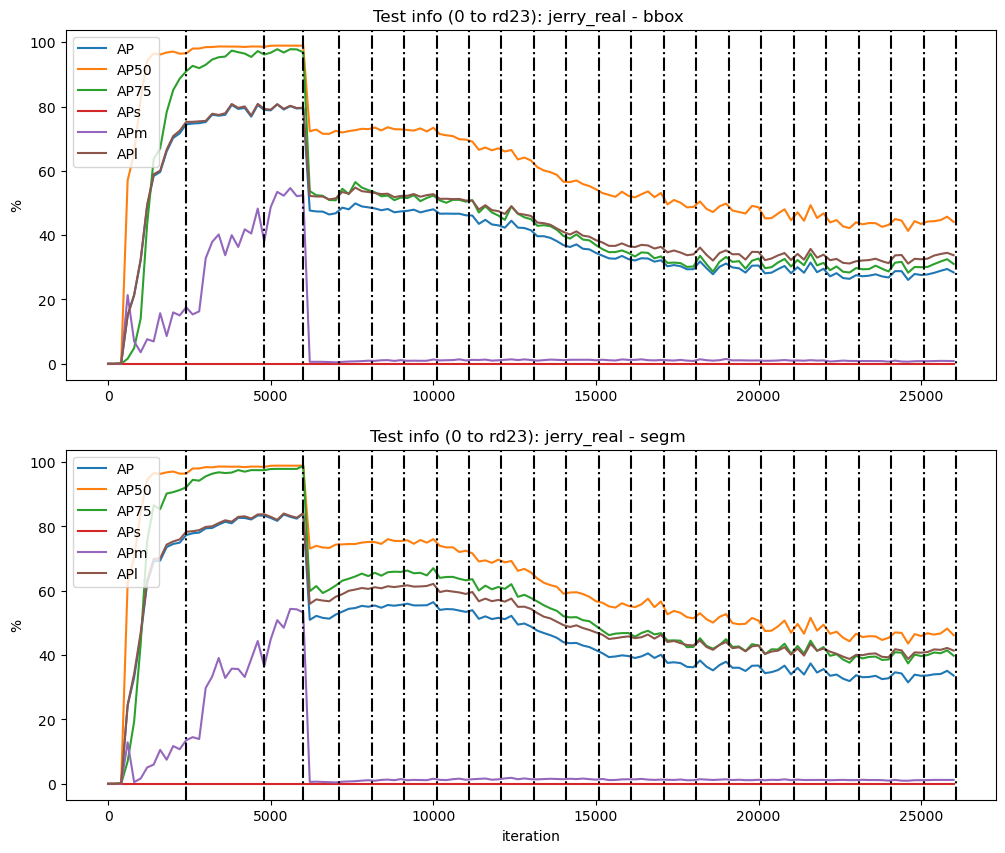

In [77]:
gatherCSVs(root_train,23,offset=4)
mergeCSVs(root_train,23,200,offset=0)
plotCSVs(root_train,23,offset=0,iter_event=[2400,4800,6000]+list(np.arange(6000+1100,19*1100+6000,999)))